# TFG - Fórmula 1 - ML

Autor: Manuel Ventura Pacheco

Creación de una NN que nos premita hacer regresión sobre el dataset que hemos preparado.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, Dropout, Input, Flatten, BatchNormalization, concatenate, AlphaDropout

from google.colab import drive
import joblib

## Carga de datos

Conectar a drive con los datos limpios en formato csv, cargarlos y comprobar los datos

In [ ]:
read_dir = '/content/drive/MyDrive/Universidad/TFG/data_ready/'
save_dir = '/content/drive/MyDrive/Universidad/TFG/models/'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(read_dir+'LEARNING_DF_NORMAL.csv')
df

,driverId,constructorId,grid,position,year,round,circuitId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,age,experience,driversPointsBeforeRace,constPointsBeforeRace
0,1,1,1,1,2008,1,1,0,0,0,0,0,8469,364,0.0,0.0
1,1,1,9,5,2008,2,2,0,0,0,0,1,8476,371,10.0,14.0
2,1,1,3,13,2008,3,3,0,0,1,0,0,8490,385,14.0,24.0
3,1,1,5,3,2008,4,4,1,0,0,0,0,8511,406,14.0,28.0
4,1,1,3,2,2008,5,5,1,0,0,0,0,8525,420,20.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25935,857,1,18,20,2023,1,3,1,0,0,0,0,8003,0,0.0,0.0
25936,857,1,8,15,2023,2,77,1,0,0,0,0,8017,14,0.0,0.0
25937,857,1,16,8,2023,3,1,1,0,0,0,0,8031,28,0.0,0.0
25938,857,1,10,11,2023,4,73,0,0,0,0,1,8059,56,4.0,12.0


## Preparar datos para entrenamiento

Transformar los datos para introducirlos en la NN:
 - Clipeamos los máximos de `grid` y `position` para que coincidan con la actual parrilla de F1. Los que antes quedaban mal siguen mal y los que empezaban últimos siguen úiltimos.
 - Fitear columnas con valores grandes al mismo rango que `grid` y `position`. También se fitean los booleanos.

In [ ]:
df = df.loc[df['year'] >= 2000].copy()

# Clipping maximuns on grid and position
df['grid'] = df['grid'].clip(upper=20)
df['position'] = df['position'].clip(upper=20)

# Fit continous columns
scaler_mm = MinMaxScaler(feature_range=(1,20))
columns_to_scale = ['year', 'age',	'experience', 'driversPointsBeforeRace', 'constPointsBeforeRace']
df[columns_to_scale] = scaler_mm.fit_transform(df[columns_to_scale])

# Fit boolean columns
columns_to_replace = ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy']
df[columns_to_replace] = df[columns_to_replace].replace(1,20)



y = df['position']
drivers = df['driverId']
constructors = df['constructorId']
circuits = df['circuitId']
X = df.drop(['driverId', 'constructorId', 'circuitId', 'position'], axis=1)

# Max index
N_DRIVERS = 858 + 1
N_CONSTRUCTORS = 214 + 1
N_CIRCUITS = 80 + 1
N_NUMERICS = X.shape[1]

## Creamos el modelo

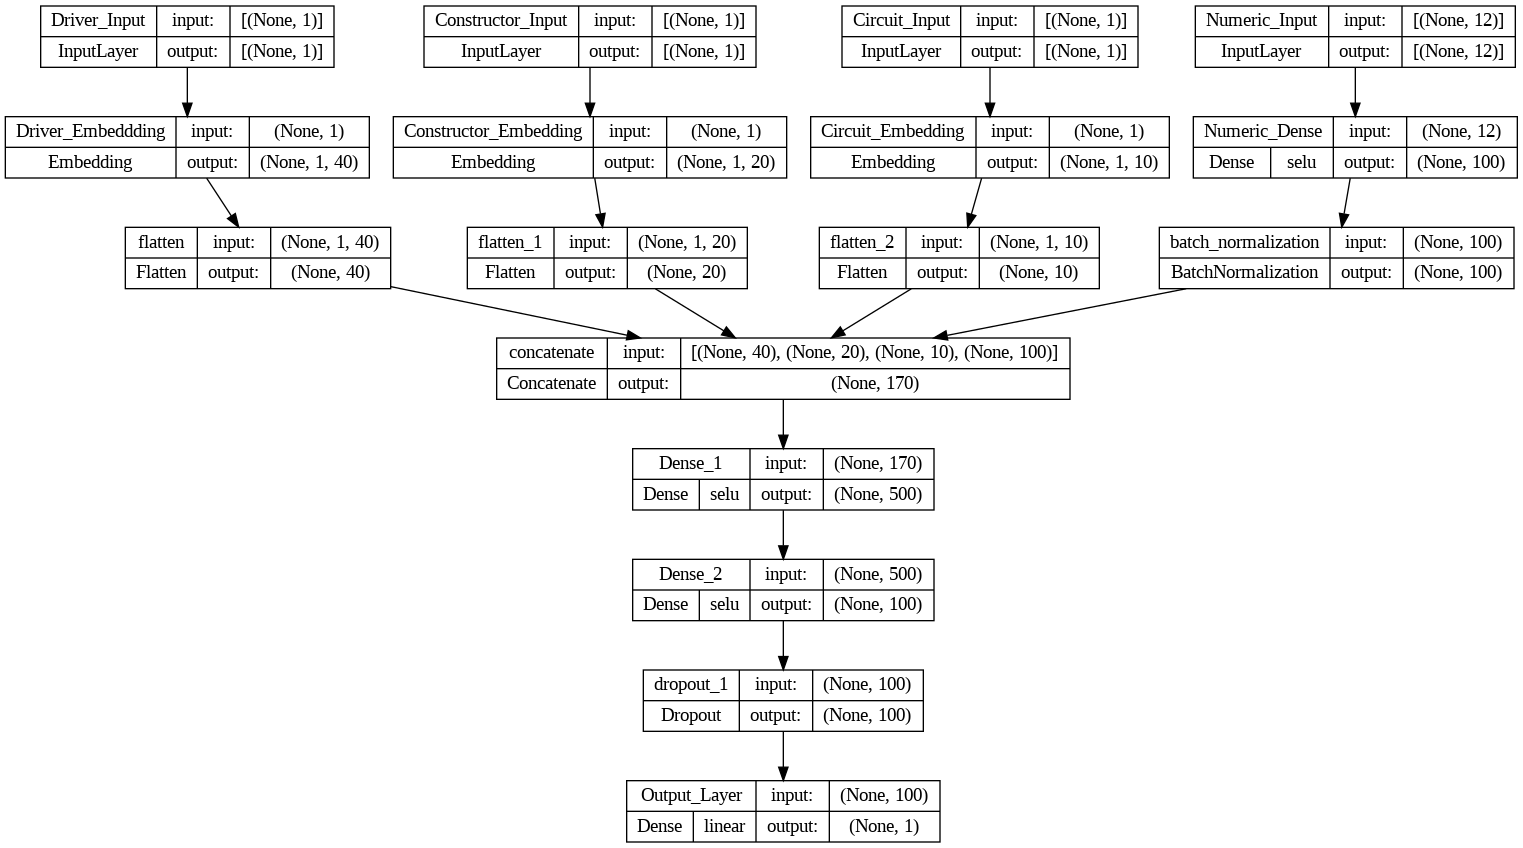

In [ ]:
activation_function = 'selu'
weight_initializer = 'lecun_uniform'





driver_input = Input(shape=(1,), name='Driver_Input')

driver_embedding = Embedding(N_DRIVERS,
                             40,
                             input_length=1,
                             embeddings_initializer=weight_initializer,
                             name='Driver_Embeddding')(driver_input)

driver_flatten = Flatten()(driver_embedding)







constructor_input = Input(shape=(1,), name='Constructor_Input')

constructor_embedding = Embedding(N_CONSTRUCTORS,
                                  20,
                                  input_length=1,
                                  embeddings_initializer=weight_initializer,
                                  name='Constructor_Embedding')(constructor_input)

constructor_flatten = Flatten()(constructor_embedding)







circuit_input = Input(shape=(1,), name='Circuit_Input')

circuit_embedding = Embedding(N_CIRCUITS,
                              10,
                              input_length=1,
                              embeddings_initializer=weight_initializer,
                              name='Circuit_Embedding')(circuit_input)

circuit_flatten = Flatten()(circuit_embedding)









numeric_inputs = Input(shape=(N_NUMERICS,),
                       name='Numeric_Input')

numeric_dense = Dense(100,
                      activation=activation_function,
                      kernel_initializer=weight_initializer,
                      name='Numeric_Dense')(numeric_inputs)

numeric_normalization = BatchNormalization()(numeric_dense)





concat_inputs = concatenate([driver_flatten, constructor_flatten, circuit_flatten, numeric_normalization])








dense_1 = Dense(500,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_1')(concat_inputs)

dense_2 = Dense(100,
                activation=activation_function,
                kernel_initializer=weight_initializer,
                name='Dense_2')(dense_1)

dropout_1 = Dropout(rate=0.3)(dense_2)

out_layer = Dense(1,
                  activation='linear',
                  name='Output_Layer')(dropout_1)



model = keras.models.Model(inputs=[driver_input, constructor_input, circuit_input, numeric_inputs],
                           outputs=out_layer)


keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_activations=True)

Creamos optimizador, callbackcs, ...

In [ ]:
optim = keras.optimizers.Nadam(learning_rate=0.001)

model.compile(optimizer=optim,
              loss='mae',
              metrics=['accuracy', 'MeanAbsoluteError'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         patience=200)

Entrenar el modelo:

In [ ]:
history = model.fit([drivers, constructors, circuits, X],
                    y,
                    batch_size=64,
                    epochs=3000,
                    shuffle = True,
                    callbacks=[callback])

Epoch 1/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.6965 - accuracy: 0.0346 - mean_absolute_error: 0.6965
Epoch 2/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.7026 - accuracy: 0.0355 - mean_absolute_error: 0.7026
Epoch 3/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.7137 - accuracy: 0.0343 - mean_absolute_error: 0.7137
Epoch 4/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.7001 - accuracy: 0.0340 - mean_absolute_error: 0.7001
Epoch 5/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.6953 - accuracy: 0.0357 - mean_absolute_error: 0.6953
Epoch 6/3000
145/145 [==============================] - 1s 6ms/step - loss: 0.7025 - accuracy: 0.0352 - mean_absolute_error: 0.7025
Epoch 7/3000
145/145 [==============================] - 1s 8ms/step - loss: 0.7056 - accuracy: 0.0346 - mean_absolute_error: 0.7056
Epoch 8/3000
145/145 [==============================] - 1s 9ms/step - loss: 

Guardar modelo y cargarlo de nuevo en caso de necesitarlo.

In [ ]:
model.save(save_dir+'nn_model_final.h5')
#joblib.dump(scaler_mm, save_dir+'minmaxscaler_nn_final.pkl')

In [ ]:
model = tf.keras.models.load_model(save_dir+'nn_model_v11.h5')


Ilustrar pérdida durante entrenamiento.

<Axes: >

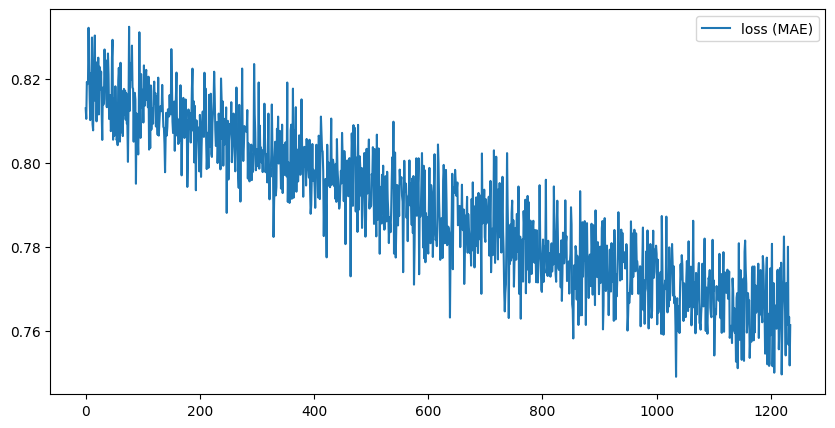

In [ ]:
pd.DataFrame({'loss (MAE)': history.history['loss']}).plot(figsize=(10,5))